### Methods

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import random
from scipy.ndimage.measurements import label
from collections import deque
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Resize image 
    resized_image = cv2.resize(img, size);
    # Create the feature vector for each color channel separately
    color1 = resized_image[:,:,0].ravel()
    color2 = resized_image[:,:,1].ravel()
    color3 = resized_image[:,:,2].ravel()
    # Stack all color channels into a single feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # scale to 0-255 instead of 0-1 from
        image = (image * 255).astype(np.uint8)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = rgb_convert_color(image,color_space)
        else:
            feature_image = np.copy(image)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# convert color from rgb to a different color space
def rgb_convert_color(img, conv='LUV'):
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, visualize_found=False, visualize_search=False):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = rgb_convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = ((nxblocks - nblocks_per_window) // cells_per_step) + 1
    nysteps = ((nyblocks - nblocks_per_window) // cells_per_step)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes_found = []
    boxes_searched = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            # get bounding box
            box = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
            if test_prediction == 1:
                boxes_found.append(box)
                if visualize_found:
                    cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                
            if (visualize_search):
                boxes_searched.append(box)
                cv2.rectangle(draw_img,box[0],box[1],(255,0,0),6) 
                
    return draw_img, boxes_found, boxes_searched

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def boxes_aggregation(deque, elem, n=6):

    ## Just at start when we don't have enough data
    if (len(deque) < n):
        deque.append(elem)
        return elem

    deque.popleft()
    deque.append(elem)
    return sum(deque, [])

### Classifier

In [2]:
from sklearn.metrics import classification_report

# Read in vehicles
vehicle_images = glob.glob('vehicles/*/*.png')
cars = []
for vehicle_image in vehicle_images:
    cars.append(vehicle_image)

# Read in non vehicles
non_vehicle_images = glob.glob('non-vehicles/*/*.png')
notcars = []
for non_vehicle_image in non_vehicle_images:
    notcars.append(non_vehicle_image)
    
random.shuffle(cars)
random.shuffle(notcars)

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Print classifaction report
print(classification_report(y_test, svc.predict(X_test)))

/home/or/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
2.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9944
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      1800
        1.0       0.99      0.99      0.99      1752

avg / total       0.99      0.99      0.99      3552



### Visualize Image Pipeline

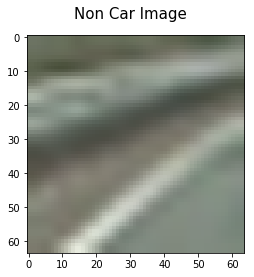

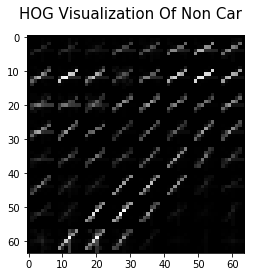

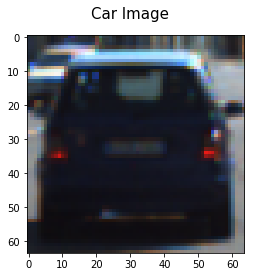

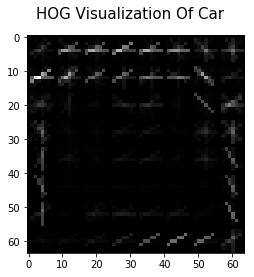

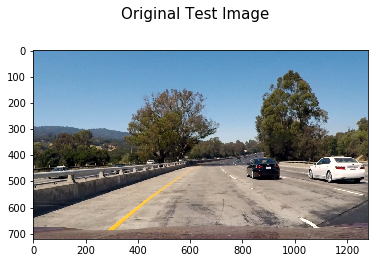

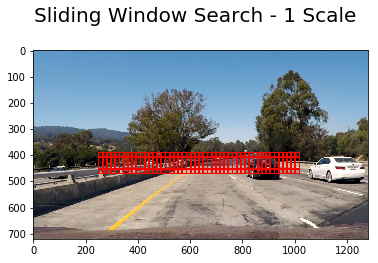

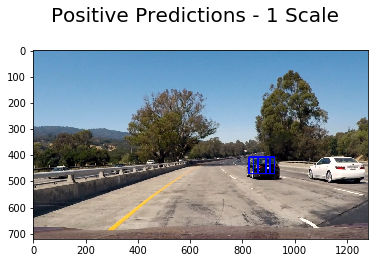

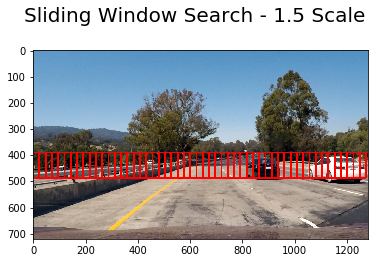

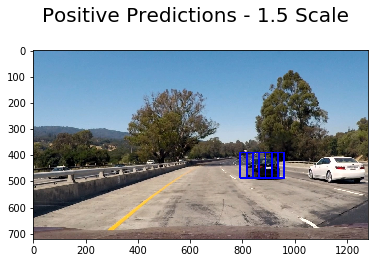

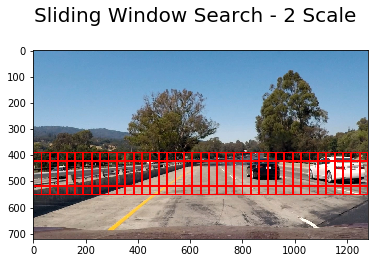

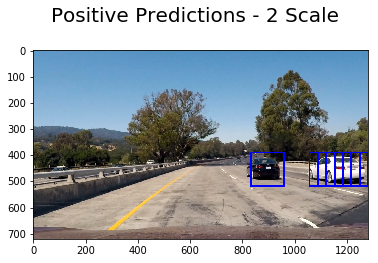

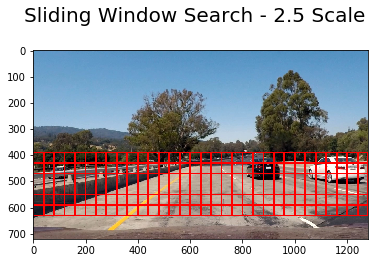

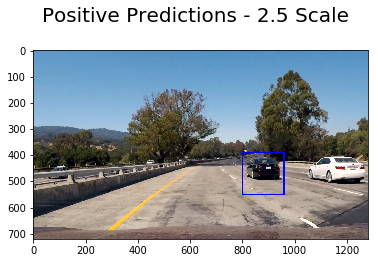

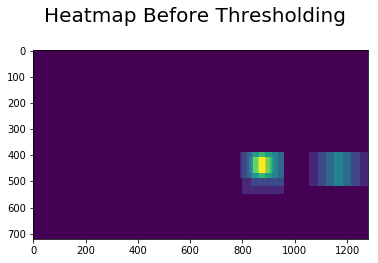

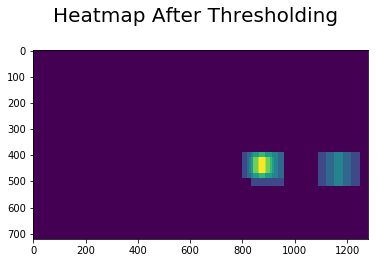

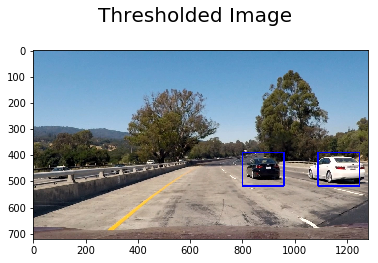

In [8]:
%matplotlib inline

# read non car image
notcar = mpimg.imread('non-vehicles/GTI/image6.png')

fignotcar1 = plt.figure()
fignotcar1.suptitle("Non Car Image", fontsize=15)
plt.imshow(notcar, cmap="gray")

# Show hog features
gray = cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, \
        vis=True, feature_vec=False)
fignotcar2 = plt.figure()
fignotcar2.suptitle("HOG Visualization Of Non Car", fontsize=15)
plt.imshow(hog_image, cmap="gray")


# read car image
car = mpimg.imread('vehicles/KITTI_extracted/5.png')

gifcar1 = plt.figure()
gifcar1.suptitle("Car Image", fontsize=15)
plt.imshow(car, cmap="gray")

# Show hog features
gray = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, \
        vis=True, feature_vec=False)
gifcar2 = plt.figure()
gifcar2.suptitle("HOG Visualization Of Car", fontsize=15)
plt.imshow(hog_image, cmap="gray")

# read test image
orig = mpimg.imread('test_images/test1.jpg')

# Show original image
fig1 = plt.figure()
fig1.suptitle("Original Test Image", fontsize=15)
plt.imshow(orig)

ystart = 390
ystop = 500
xstart = 250
xstop = orig.shape[1] - xstart
scale = 1

window_img, boxes_found_ignore, boxes_searched_ignore = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, False, True)
fig2 = plt.figure()
fig2.suptitle("Sliding Window Search - 1 Scale",fontsize=20)
plt.imshow(window_img)

window_img, boxes_found1, boxes_searched1 = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
fig3 = plt.figure()
fig3.suptitle("Positive Predictions - 1 Scale",fontsize=20)
plt.imshow(window_img)

ystart = 390
ystop = 530
xstart = 0
xstop = orig.shape[1] - xstart
scale = 1.5

window_img, boxes_found_ignore, boxes_searched_ignore = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, False, True)
fig4 = plt.figure()
fig4.suptitle("Sliding Window Search - 1.5 Scale",fontsize=20)
plt.imshow(window_img)

window_img, boxes_found2, boxes_searched2 = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
fig5 = plt.figure()
fig5.suptitle("Positive Predictions - 1.5 Scale",fontsize=20)
plt.imshow(window_img)

ystart = 390
ystop = 600
xstart = 0
xstop = orig.shape[1] - xstart
scale = 2

window_img, boxes_found_ignore, boxes_searched_ignore = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, False, True)
fig6 = plt.figure()
fig6.suptitle("Sliding Window Search - 2 Scale",fontsize=20)
plt.imshow(window_img)

window_img, boxes_found3, boxes_searched3 = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
fig7 = plt.figure()
fig7.suptitle("Positive Predictions - 2 Scale",fontsize=20)
plt.imshow(window_img)

ystart = 390
ystop = 695
xstart = 0
xstop = orig.shape[1] - xstart
scale = 2.5

window_img, boxes_found_ignore, boxes_searched_ignore = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, False, True)
fig8 = plt.figure()
fig8.suptitle("Sliding Window Search - 2.5 Scale",fontsize=20)
plt.imshow(window_img)

window_img, boxes_found4, boxes_searched4 = find_cars(orig, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
fig9 = plt.figure()
fig9.suptitle("Positive Predictions - 2.5 Scale",fontsize=20)
plt.imshow(window_img)

# All box lists concat
boxes = boxes_found1 + boxes_found2 + boxes_found3 + boxes_found4

heat = np.zeros_like(orig[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,boxes)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Show thresholded image
fig10 = plt.figure()
fig10.suptitle("Heatmap Before Thresholding",fontsize=20)
plt.imshow(heatmap)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Show thresholded image
fig11 = plt.figure()
fig11.suptitle("Heatmap After Thresholding",fontsize=20)
plt.imshow(heatmap)

# Find final boxes from heatmap using label function
labels_list = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(orig), labels_list)

# Show thresholded image
fig12 = plt.figure()
fig12.suptitle("Thresholded Image",fontsize=20)
plt.imshow(draw_img)
        
plt.show()

### Visualize Image Processing On Test Images

/home/or/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


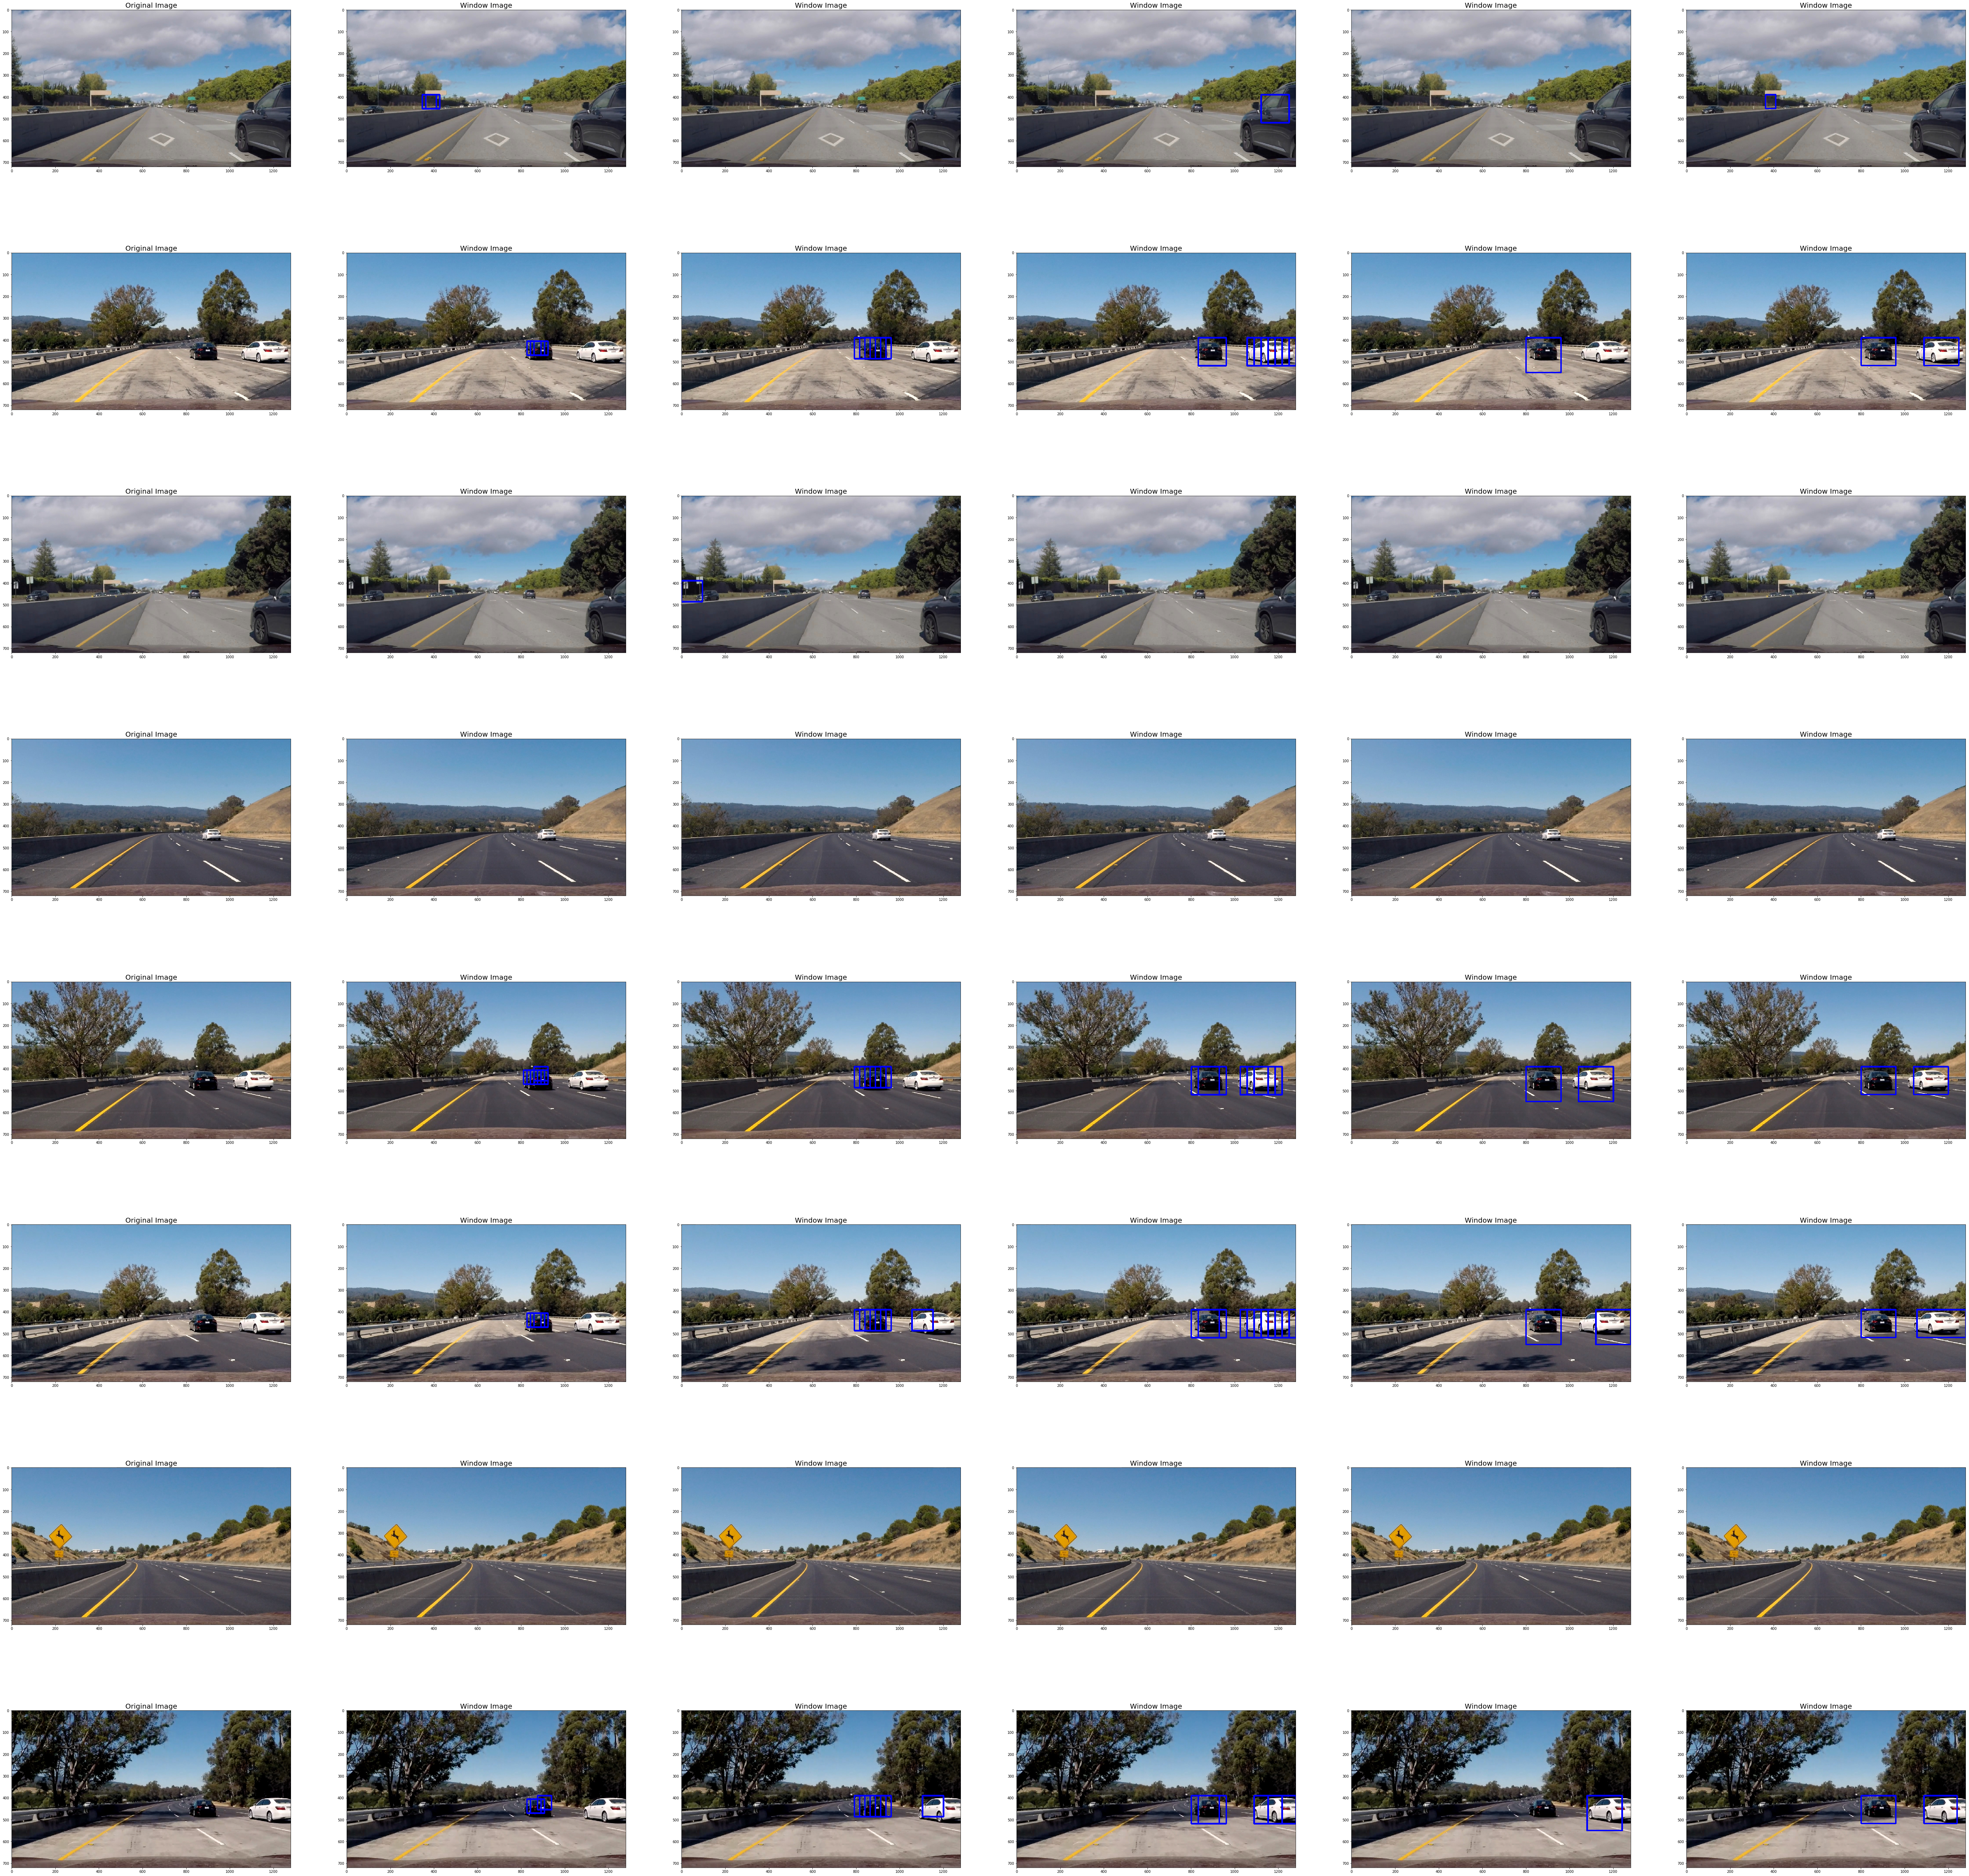

In [4]:
# Read in all test images
test_images_path = glob.glob('test_images/*.jpg')
test_images_count = len(test_images_path)
test_images = []
for test_image_path in test_images_path:
    img = mpimg.imread(test_image_path)
    test_images.append(img)                       

%matplotlib inline

x_axis = 6
y_axis = test_images_count

fig, ax = plt.subplots(y_axis,x_axis)
fig.set_size_inches(100, 100)

i = 0; # image counter
for image in test_images:
    # Show original image
    ax[i][0].set_title("Original Image",fontsize=20)
    ax[i][0].imshow(image)
    
    ystart = 390
    ystop = 500
    xstart = 250
    xstop = image.shape[1] - xstart
    scale = 1
    window_img, boxes_found1, boxes_searched1 = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
    # Show window image
    ax[i][1].set_title("Window Image",fontsize=20)
    ax[i][1].imshow(window_img)
    
    ystart = 390
    ystop = 530
    xstart = 0
    xstop = image.shape[1] - xstart
    scale = 1.5
    window_img, boxes_found2, boxes_searched2 = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
    # Show window image
    ax[i][2].set_title("Window Image",fontsize=20)
    ax[i][2].imshow(window_img)
    
    ystart = 390
    ystop = 600
    xstart = 0
    xstop = image.shape[1] - xstart
    scale = 2
    window_img, boxes_found3, boxes_searched3 = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
    # Show window image
    ax[i][3].set_title("Window Image",fontsize=20)
    ax[i][3].imshow(window_img)
    
    ystart = 390
    ystop = 695
    xstart = 0
    xstop = image.shape[1] - xstart
    scale = 2.5
    window_img, boxes_found4, boxes_searched4 = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, True, False)
    # Show window image
    ax[i][4].set_title("Window Image",fontsize=20)
    ax[i][4].imshow(window_img)
    
    # All box lists concat
    boxes = boxes_found1 + boxes_found2 + boxes_found3 + boxes_found4
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels_list = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels_list)
    
     # Show window image
    ax[i][5].set_title("Window Image",fontsize=20)
    ax[i][5].imshow(draw_img)
    
    # Increment image counter
    i += 1
        
plt.show()

### Pipeline

In [5]:
fps = 25 # Frames per second
# Take into considertaion the last few frames(not much relative movement)
# to help remove outliers
num_of_frames_to_queue = int(fps / 2.5)
heatmap_threshold = int(num_of_frames_to_queue / 1.2)
boxes_aggregation_deque = deque([], maxlen=num_of_frames_to_queue)

searchs_configuration = [(390,500,250,image.shape[1]-250,1),(390,530,0,image.shape[1],1.5)\
                       ,(390,600,0,image.shape[1],2),(390,695,0,image.shape[1],2.5)]

def process_image(image):
    # All multi scale matches should be in boxes list
    boxes = []
    
    for search_configuration in searchs_configuration:
        ystart = search_configuration[0]
        ystop = search_configuration[1]
        xstart = search_configuration[2]
        xstop = search_configuration[3]
        scale = search_configuration[4]
        window_image, boxes_found,  boxes_search = find_cars(image, ystart, ystop, xstart,\
            xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,\
            hist_bins, color_space, False, False)
        
        # Add new boxes to found boxes list
        boxes += boxes_found

    # Aggregate from past box lists
    boxes_aggregate = boxes_aggregation(boxes_aggregation_deque, boxes, num_of_frames_to_queue)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_aggregate)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heatmap_threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    return draw_img

### Test On Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [08:42<00:00,  2.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 11min 55s, sys: 2.59 s, total: 11min 57s
Wall time: 8min 43s
